# IMAGE SEGMENTATION

0.60939 (early stopping)

test dice loss 0,68

0.60600 normalization

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import os
import PIL

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard

%matplotlib inline
!pip install -U tensorflow-addons
!pip install livelossplot
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from tensorflow_addons.layers import GroupNormalization
from sklearn.preprocessing import MinMaxScaler


In [3]:
print("TensorFlow version: ",tf.__version__)

TensorFlow version:  2.7.0


Checking the available CPU and GPU devices

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
Num CPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Initial Preparation

### Train data

Setting the path to train images and masks.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_x_loc = "/content/drive/MyDrive/DL/train_images.zip (Unzipped Files)/train_images/"
train_y_loc = "/content/drive/MyDrive/DL/train_masks.zip (Unzipped Files)/train_masks/"

Extract the names of the image files and sort and store them in a list. This will later be iterated over to read and store the image and mask data.

In [7]:
img_names = [s[:-4] for s in os.listdir(train_x_loc)]

In order to prevent clogging up the RAM, we will create batches of images.

In [8]:
TRAIN_BATCH_SIZE = 87

In [9]:
img_names_batches = [img_names[i:i + TRAIN_BATCH_SIZE] for i in range(0, len(img_names), TRAIN_BATCH_SIZE)]
print("Train images were split into batches of size {}.".format(TRAIN_BATCH_SIZE))
print("Number of batches = ",len(img_names_batches))

Train images were split into batches of size 87.
Number of batches =  3


### Image Configs

In [67]:
INPUT_SIZE = 256
N_CHANNEL = 3
N_CLASSES = 27

## Model Creation

### UNet

In [68]:
def get_unet():
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.2)(pool1) # Dropout(0.2)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.2)(pool2) #Dropout(0.2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.2)(pool3) 

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.2)(pool4) # Dropout(0.2)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation="softmax")(conv9) #

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

    return model
    
def get_unet2(): #testing groupNormalization
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    #conv1 = GroupNormalization(groups=4,axis=2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.2)(pool1) # Dropout(0.2)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    #conv2 = GroupNormalization(groups=4)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.2)(pool2) #Dropout(0.2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    #conv3 = GroupNormalization(groups=4)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.2)(pool3) 

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    #conv4 = GroupNormalization(groups=4)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.2)(pool4) # Dropout(0.2)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation="softmax")(conv9) #

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

    return model

In semantic segmentation, you need as many masks as you have object classes. 
In our dataset, each pixel in every mask has been assigned a single integer probability that it belongs to a 
certain class - 0 to 26. The correct class is the one with the highest probability. 

Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with 
lots of classes and to perform pixel-wise multiclass prediction. 

## Training the model

### Creating CallBacks

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

In [69]:
# TensorBoard visuluaziations
# To visualize, execute the following commands in a new jupyter notebook:
# %load_ext tensorboard
# %tensorboard --logdir /tmp/tboard_logs8
tensorboard = TensorBoard(log_dir='/tmp/tboard_logs8', histogram_freq=0, write_graph=True, write_images=True)

class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_batch_begin(self, batch, logs=None):
    print('\nTraining: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_train_batch_end(self, batch, logs=None):
    print('\nTraining: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_begin(self, batch, logs=None):
    print('\nEvaluating: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_end(self, batch, logs=None):
    print('\nEvaluating: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

#Other callbacks
early_stopping = EarlyStopping(monitor="accuracy",patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

Defining Loss

In [70]:
import keras.losses 
from keras.metrics import binary_crossentropy
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)= sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.Ref: https://en.wikipedia.org/wiki/Jaccard_index
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.cast(y_pred > t, tf.int32) #tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

keras.losses.custom_objects = bce_dice_loss
# keras.api._v2.keras.metrics.custom_objects = mean_iou

# tf.keras.utils.get_custom_objects()['bce_dice_loss'] = bce_dice_loss
# tf.keras.utils.get_custom_objects()['mean_iou'] = mean_iou

### Training

In [14]:
# img_names_batches = [img_names_batches[0]]

In [15]:
for i, imgnames in enumerate(img_names_batches):
    print(i, len(imgnames))

0 87
1 87
2 87


In [71]:
from tensorflow.python.keras.metrics import Metric

# Training configs
EPOCHS = 30 #25-100
LEARNING_RATE = 0.001 #3e-14
TRAINING_SAVE_LOC = "saved_models/training_20/"

model = None
scaler = MinMaxScaler()
train_hist = {}
import random

for b,img_names in enumerate(img_names_batches):
#     if len(img_names) > 90:
#         EPOCHS = 30
#         print("EPOCHS set to ", EPOCHS)
#     elif len(img_names) < 70:
#         EPOCHS = 5
#         print("EPOCHS set to ", EPOCHS)
#     else:
#         EPOCHS = 20
#         print("EPOCHS set to ", EPOCHS)
    
    # Setting the model
    if model is None:
        print("No model set. Creating new model.")
        model = get_unet()
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss= bce_dice_loss, metrics=['accuracy']) #loss =tf.keras.losses.CategoricalCrossentropy(from_logits=False)
        INITIAL_TRAIN = False
        print("UNet model created from scratch.")
    # else:
    #      model = tf.keras.models.load_model(TRAINING_SAVE_LOC + "batch_" + str(b - 1) + "/", custom_objects={"CustomModel": mean_iou})
    #      print("UNet model loaded from ", TRAINING_SAVE_LOC + "batch_" + str(b - 1) + "/") 
    # if model is None:
    #          print("!!! MODEL NOT SET !!!")
    #          break
              
    # Preparing the data
    x = []
    y = []
    print("Reading train data")
    for i in img_names:
        x.append(np.array(PIL.Image.open(train_x_loc + i + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255.)
        y.append(to_categorical(np.array(PIL.Image.open(train_y_loc + i + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST)), N_CLASSES))
    x = np.array(x)
    #x_mean = x.mean() #centering pixels
    #x = x - x_mean #centering pixels
    y = np.array(y)
    #flip = random.randint(0, 1)
    #if flip:
    x = np.append(x, [np.fliplr(i) for i in x], axis=0) #data augmentation (flipping)
    y = np.append(y, [np.fliplr(i) for i in y], axis=0) #data augmentation (flipping)

    # Reserve samples for validation
    val_samples = 27
    x_train = x[:-val_samples]
    print("x train ---- ", len(x_train))
    y_train = y[:-val_samples]
    x_val = x[-val_samples:]
    print("x val ---- ", len(x_val))
    y_val = y[-val_samples:]
    del x,y
    print("Train and Validation data created")
    
    # Training the model
    model_history = model.fit(x_train, y_train, batch_size=5, epochs=EPOCHS, validation_data=(x_val, y_val), shuffle=True, callbacks=[MyCustomCallback(),tensorboard,model_checkpoint])
    train_hist[b] = model_history
    print("Train hist recorded for batch - ",b)
    #del x_train,y_train,x_val,y_val
    
    # Saving the model
    print("Saving the model")
    BATCH_LOC = "batch_" + str(b) + "/"
    CURRENT_SAVE_LOC = TRAINING_SAVE_LOC + BATCH_LOC
    #model.save(CURRENT_SAVE_LOC)
    #model.save(CURRENT_SAVE_LOC,save_format='h5')
    print("Saved the model at", CURRENT_SAVE_LOC)

    #0.645 com early stopping
    #0.66 sem early stopping
    

Streaming output truncated to the last 5000 lines.
18/30 [=================>............] - ETA: 0s - loss: 1.0158 - accuracy: 0.1880
Training: batch 18 begins at 12:11:33.441765

Training: batch 18 ends at 12:11:33.484239

Training: batch 19 begins at 12:11:33.485610

Training: batch 19 ends at 12:11:33.527240
20/30 [===================>..........] - ETA: 0s - loss: 1.0071 - accuracy: 0.1962
Training: batch 20 begins at 12:11:33.529542

Training: batch 20 ends at 12:11:33.571658

Training: batch 21 begins at 12:11:33.572927

Training: batch 21 ends at 12:11:33.620856
22/30 [=====================>........] - ETA: 0s - loss: 1.0056 - accuracy: 0.1991
Training: batch 22 begins at 12:11:33.623656

Training: batch 22 ends at 12:11:33.665385

Training: batch 23 begins at 12:11:33.666757

Training: batch 23 ends at 12:11:33.708380
24/30 [=======================>......] - ETA: 0s - loss: 1.0037 - accuracy: 0.1994
Training: batch 24 begins at 12:11:33.710788

Training: batch 24 ends at 12:11:3

training_11 is the best train acc as of now but kaggle acc - 0.60
training_13 is the best kaggle acc with 0.62
training_12 - 261 - sftm kaggle acc was still 0.60
training_15 - reduced epoch - kaggle 0.64
training_16 - reduced epoch still - BEST kaggle 0.67
training_19 - diff approach - 3 batches of 87 each - kaggle 0.66
t_20 - 87-batch - model on 2 batch seems to perform good - kaggle 0.65

setttings for training_15:
    if len(img_names) > 90:
        EPOCHS = 35
        print(" EPOCHS set to ", EPOCHS)
    elif len(img_names) < 70:
        EPOCHS = 5
        print(" EPOCHS set to ", EPOCHS)
    else:
        EPOCHS = 20
        print(" EPOCHS set to ", EPOCHS)
    >>>>>>> and <<<<<<<<
    90 - train; 10 - val

settings for training_16: 
    if len(img_names) > 90:
        EPOCHS = 25
        print("EPOCHS set to ", EPOCHS)
    elif len(img_names) < 70:
        EPOCHS = 5
        print("EPOCHS set to ", EPOCHS)
    else:
        EPOCHS = 20
        print("EPOCHS set to ", EPOCHS)
        >>>>>>> and <<<<<<<
    80 - train; 20 - val
        

settings for training_19:
epochs = 20 >>>>>> and <<<<<< 70 - train; 17 - val

settings for t_20:
epochs = 20 and t/v = 60/27

## Visualize Training history

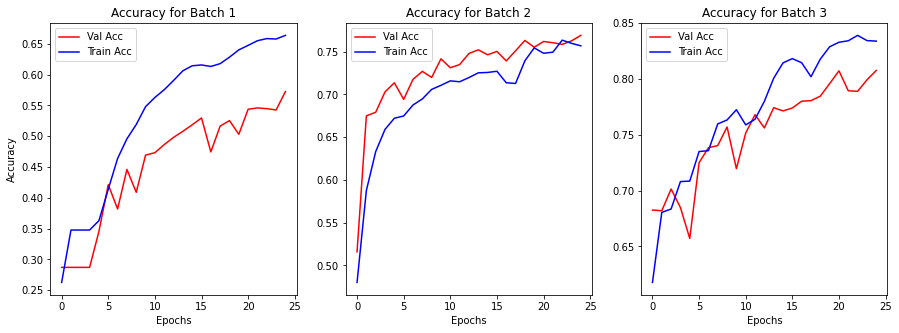

In [251]:
def visualise_train_hist(hist_dict, metric="acc"):
    if metric == "loss":
        y_lbl = "Loss"
        titl = "Loss"
        
        train_met = "loss"
        train_lbl = "Train Loss"
        
        val_met = "val_loss"
        val_lbl = "Val Loss"
    else:
        y_lbl = "Accuracy"
        titl = "Accuracy"
        
        train_met = "accuracy"
        train_lbl = "Train Acc"
        
        val_met = "val_accuracy"
        val_lbl = "Val Acc"
        
        
    batch_0_hist = hist_dict[0]
    batch_1_hist = hist_dict[1]
    batch_2_hist = hist_dict[2]
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    
    axs[0].plot(batch_0_hist.epoch,batch_0_hist.history[val_met], color="red", label = val_lbl)
    axs[0].plot(batch_0_hist.epoch,batch_0_hist.history[train_met], color="blue", label = train_lbl)
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel(y_lbl)
    axs[0].set_title(titl + ' for Batch 1')
    axs[0].legend(loc='upper left')
    
    axs[1].plot(batch_1_hist.epoch,batch_1_hist.history[val_met], color="red", label = val_lbl)
    axs[1].plot(batch_1_hist.epoch,batch_1_hist.history[train_met], color="blue", label = train_lbl)
    axs[1].set_xlabel('Epochs')
    axs[1].set_title(titl + ' for Batch 2')
    axs[1].legend(loc='upper left')
    
    axs[2].plot(batch_2_hist.epoch,batch_2_hist.history[val_met], color="red", label = "Val Acc")
    axs[2].plot(batch_2_hist.epoch,batch_2_hist.history[train_met], color="blue", label = train_lbl)
    axs[2].set_xlabel('Epochs')
    axs[2].set_title(titl + ' for Batch 3')
    axs[2].legend(loc='upper left')

visualise_train_hist(train_hist) # , metric="loss"

In [72]:
loss, acc = model.evaluate(x_val, y_val, verbose=2)

1/1 - 0s - loss: 0.8873 - accuracy: 0.2854 - 222ms/epoch - 222ms/step


## Prediction

In [253]:
model

In [247]:
#model.load_weights('./keras.model') 

In [55]:
loss, acc = model.evaluate(x_val, y_val, verbose=2)

1/1 - 0s - loss: 0.2607 - accuracy: 0.8005 - 171ms/epoch - 171ms/step


### Test data

Setting the path to test images. `test_y_loc` is the location where the predicted outputs should be saved.

In [234]:
test_x_loc = "/content/drive/MyDrive/DL/test_images.zip (Unzipped Files)/test_images/"
test_y_loc = "/content/drive/MyDrive/DL/test_images.zip (Unzipped Files)/test_preds/"

Extract the names of the test images and sort them and store them in a list.

In [235]:
test_img_names = sorted([s[:-4] for s in os.listdir(test_x_loc)])

In [236]:
print("Number of test images = ", len(test_img_names))

Number of test images =  112


### Ready the model

If `USE_CURRENT_MODEL` is False, then provide the location of the saved model you want to use in `SAVED_MODEL_LOC`.

In [50]:
USE_CURRENT_MODEL = True #False
SAVED_MODEL_LOC = TRAINING_SAVE_LOC + "batch_0/" # "saved_models/training_11/"

In [51]:
if not USE_CURRENT_MODEL:
    model = tf.keras.models.load_model(SAVED_MODEL_LOC)
    print("Model loaded from ", SAVED_MODEL_LOC)

### Predict the output and save the mask as .png file

> Indented block



In [260]:
def get_predictions(image_loc, test_img_names):
    y_test = {}
    print("Predicting for {} images".format(len(test_img_names)))
    for i in test_img_names:
        print("Predicting for img",i)
        x_test = np.array(PIL.Image.open(image_loc + i + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255 #
        x_test = x_test.reshape((1,INPUT_SIZE,INPUT_SIZE,3))
        #x_test_mean = x_test.mean()
        #x_test = x_test - x_test_mean
        y_test[i] = model.predict(x_test, verbose=1)
        del x_test
    return y_test

def create_mask(image_dict):
    y_test_mask = {}
    print("Creating masks for {} predictions".format(len(image_dict)))
    for name, img in image_dict.items():
        pred_mask = tf.argmax(img, axis=3)
        pred_mask= np.uint8(pred_mask[0].numpy())
        y_test_mask[name] = pred_mask
    return y_test_mask
        
def save_mask(mask_dict):
    for name, mask in mask_dict.items():
        im = PIL.Image.fromarray(mask)
        im.save(test_y_loc + name + '.png')
        print("Image saved: ", test_y_loc + name + '.png')

preds = get_predictions(test_x_loc,test_img_names)
masks = create_mask(preds)
save_mask(masks)



Predicting for 112 images
Predicting for img 10170
1/1 [==============================] - 0s 22ms/step
Predicting for img 10171
1/1 [==============================] - 0s 21ms/step
Predicting for img 10184
1/1 [==============================] - 0s 21ms/step
Predicting for img 10566
1/1 [==============================] - 0s 21ms/step
Predicting for img 10808
1/1 [==============================] - 0s 22ms/step
Predicting for img 10812
1/1 [==============================] - 0s 21ms/step
Predicting for img 6413
1/1 [==============================] - 0s 20ms/step
Predicting for img 6424
1/1 [==============================] - 0s 21ms/step
Predicting for img 6427
1/1 [==============================] - 0s 20ms/step
Predicting for img 6450
1/1 [==============================] - 0s 20ms/step
Predicting for img 6455
1/1 [==============================] - 0s 20ms/step
Predicting for img 6457
1/1 [==============================] - 0s 20ms/step
Predicting for img 6459
1/1 [===========================

### Saving the output for kaggle submission

In [261]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles(test_pred_dir):
    """Used for Kaggle submission: predicts and encode all test images"""
    N = len([i for i in list(os.listdir(test_pred_dir)) if i[-3:] == "png"])
    with open('/content/drive/MyDrive/DL/submissions/submission_file17.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(test_pred_dir)):
            if i[-3:] == "png":
                print('Saving {}/{}'.format(index, N))
                mask = PIL.Image.open(test_pred_dir + i)
                mask = mask.resize((INPUT_SIZE, INPUT_SIZE), resample= PIL.Image.NEAREST)
                mask = np.array(mask)

                for x in range(1, 25):
                    enc = rle_encode(mask == x)
                    f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles(test_y_loc) 

Saving 0/112
Saving 1/112
Saving 2/112
Saving 3/112
Saving 4/112
Saving 5/112
Saving 6/112
Saving 7/112
Saving 8/112
Saving 9/112
Saving 10/112
Saving 11/112
Saving 12/112
Saving 13/112
Saving 14/112
Saving 15/112
Saving 16/112
Saving 17/112
Saving 18/112
Saving 19/112
Saving 20/112
Saving 21/112
Saving 22/112
Saving 23/112
Saving 24/112
Saving 25/112
Saving 26/112
Saving 27/112
Saving 28/112
Saving 29/112
Saving 30/112
Saving 31/112
Saving 32/112
Saving 33/112
Saving 34/112
Saving 35/112
Saving 36/112
Saving 37/112
Saving 38/112
Saving 39/112
Saving 40/112
Saving 41/112
Saving 42/112
Saving 43/112
Saving 44/112
Saving 45/112
Saving 46/112
Saving 47/112
Saving 48/112
Saving 49/112
Saving 50/112
Saving 51/112
Saving 52/112
Saving 53/112
Saving 54/112
Saving 55/112
Saving 56/112
Saving 57/112
Saving 58/112
Saving 59/112
Saving 60/112
Saving 61/112
Saving 62/112
Saving 63/112
Saving 64/112
Saving 65/112
Saving 66/112
Saving 67/112
Saving 68/112
Saving 69/112
Saving 70/112
Saving 71/112
Sa

## Making a kaggle submission

Make sure you have installed the kaggle package and completed all the steps listed here : https://medium.com/@jeff.daniel77/accessing-the-kaggle-com-api-with-jupyter-notebook-on-windows-d6f330bc6953

In [221]:
!kaggle competitions submit -c fdl21-fdl-dsba -f submissions/submission_file.csv -m "batch 87 change t20 m0"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


## Visualise the output of the model prediction

Predicting for 1 images
Predicting for img 6456
1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Creating masks for 1 predictions
dict_keys(['6456'])


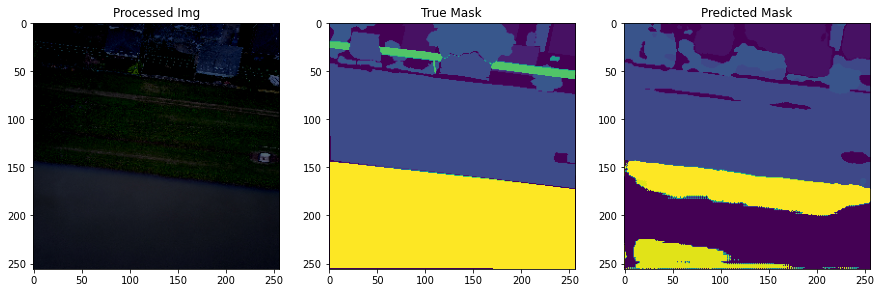

In [262]:
def visualise_test(image_name):

    img1 = np.array(PIL.Image.open(test_x_loc + image_name +'.jpg').resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255
    img2 = mpimg.imread(test_y_loc + image_name +'.png')
    # mpimg.imread(test_x_loc + '6413.jpg')

    fig, axs = plt.subplots(1, 2, figsize=(15, 15))
    axs[0].imshow(img1)
    axs[0].set_title('Processed Img')
    axs[1].imshow(img2)
    axs[1].set_title('Predicted img')
    
def visualise_train(image_name):

    img1 = np.array(PIL.Image.open(train_x_loc + image_name +'.jpg').resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255
    #img1_mean = img1.mean()
    #img1 = img1 - img1_mean
    img2 = np.array(PIL.Image.open(train_y_loc + image_name + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))
    # mpimg.imread(train_y_loc + image_name +'.png')
    # mpimg.imread(test_x_loc + '6413.jpg')

    img_name = [image_name]
    pred = get_predictions(train_x_loc,img_name)
    mask = create_mask(pred)
    print(mask.keys())
    img3 = mask[image_name]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(img1)
    axs[0].set_title('Processed Img')
    axs[1].imshow(img2)
    axs[1].set_title('True Mask')
    axs[2].imshow(img3)
    axs[2].set_title('Predicted Mask')
    
assert(model is not None)
# visualise_test('') # provide only image names from 'test_images'
visualise_train('6456') # provide only image names from 'train_images'